In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from matplotlib.dates import MonthLocator, DateFormatter


In [3]:
S_0 = 1360 # Solar constant [W/m2]
d_n = np.array(range(365)) # days
th_d = 2*np.pi*d_n/365

In [4]:
# Fourier series coefficients 
a_n = np.array([1.000110, 0.034221, 0.000719])
b_n = np.array([0, 0.001280, 0.000077])
n = len(a_n)

In [5]:
complex_terms = a_n + 1j * b_n
result = np.sum(complex_terms * np.exp(-1j * np.outer(th_d, np.arange(n))), axis=1)
d_ratio_sq = np.real(result) # (mean distance Earth-Sun / actual distance on that day)^2 --> depends on days

In [6]:
# Fourier series coefficients 
a_n = np.array([0.006918, -0.399912, -0.006758, -0.002697])
b_n = np.array([0, 0.070257, 0.000907, 0.001480])
n = len(a_n)

In [7]:
complex_terms = a_n + 1j * b_n
result = np.sum(complex_terms * np.exp(-1j * np.outer(th_d, np.arange(n))), axis=1)
delta = np.real(result) # declination angle --> depends on days

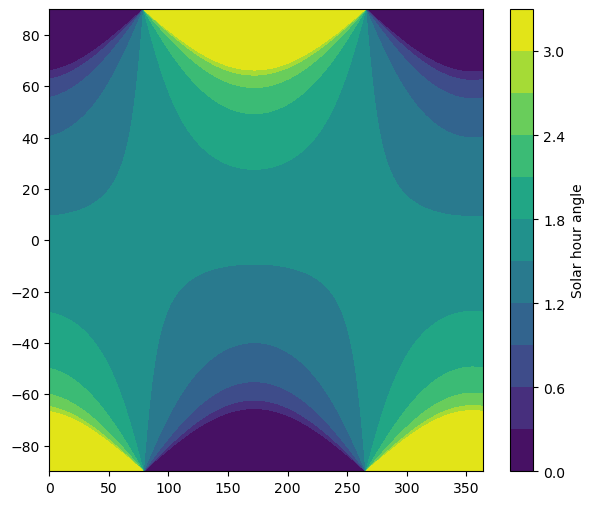

In [8]:
steps = int(180/0.01 + 1)
phi_lat = np.linspace(-90, 90, steps) # latitude in degrees
# phi_lat = np.arange(-90, 90.01, 0.01) # latitude in degrees this gives a slight error
tan_product = -np.outer(np.tan(np.radians(phi_lat)), np.tan(delta)) # depends on lat

tan_product = np.clip(tan_product, -1, 1) # some values are out of cosine range

h = np.arccos(tan_product) # hour angle at sunrise and sunset --> depends on lat and days (symmetrical around solar noon)

plt.figure(figsize=(7, 6))
contour = plt.contourf(d_n, phi_lat, h, cmap='viridis', levels=10)
plt.colorbar(contour, label='Solar hour angle')
plt.show()

In [9]:
phi_lat[-1]

90.0

In [10]:
Q_par1 = h * np.outer(np.sin(np.radians(phi_lat)), np.sin(delta) * d_ratio_sq) 
Q_par2 = np.sin(h) * np.outer(np.cos(np.radians(phi_lat)), np.cos(delta) * d_ratio_sq) 
Q = S_0 * (Q_par1 + Q_par2) / np.pi # TOA daily average insolation

In [11]:
# Q = np.clip(Q, a_min=0, a_max=None)

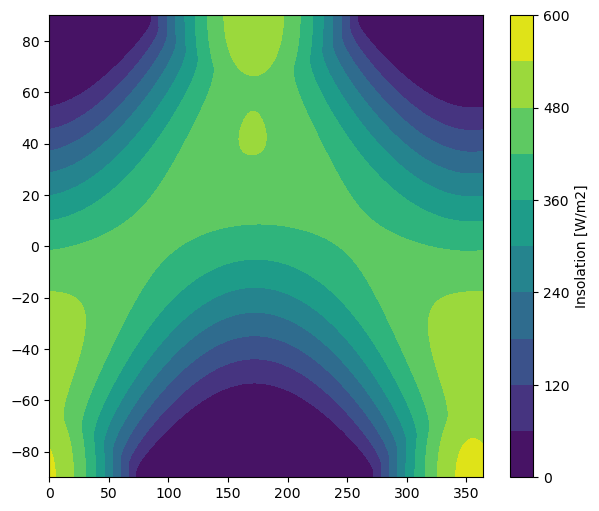

In [12]:
plt.figure(figsize=(7, 6))
contour = plt.contourf(d_n, phi_lat, Q, cmap='viridis', levels=10)
plt.colorbar(contour, label='Insolation [W/m2]')
plt.show()

In [13]:
start_date = datetime.strptime('2024-01-01', '%Y-%m-%d') 
dates = [start_date + timedelta(days=int(day)) for day in d_n]

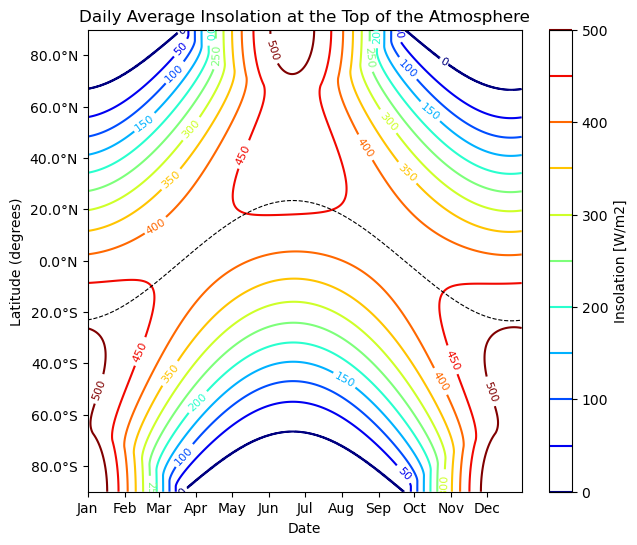

In [14]:
plt.figure(figsize=(7, 6))
contour = plt.contour(dates, phi_lat, Q, cmap='jet', levels=np.linspace(0, 500, 11))
plt.clabel(contour, inline=True, fontsize=8, fmt='%d')

plt.plot(dates, np.degrees(delta), 'k--', linewidth=0.8)

# Customize the x-axis ticks to show only month names
plt.gca().xaxis.set_major_locator(MonthLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%b'))

# Customize the y-axis ticks to show #N for positive values and #S for negative values
plt.gca().yaxis.set_major_formatter(lambda value, tick_number: f'{abs(value)}°{"N" if value >= 0 else "S"}')

plt.colorbar(contour, label='Insolation [W/m2]')
plt.xlabel('Date')
plt.ylabel('Latitude (degrees)')
plt.title('Daily Average Insolation at the Top of the Atmosphere')
plt.show()

In [15]:
'''
Calculate TOA Daylight hours
'''

'\nCalculate TOA Daylight hours\n'

In [16]:
daylight_hours = 2*h*180/(np.pi*15) # 1/15 converts the angle from degrees to hours, x2 to account two periods around solar noon

In [17]:
daylight_hours.max()

24.000000000000004

In [26]:
daylight_hours = daylight_hours.round(8)

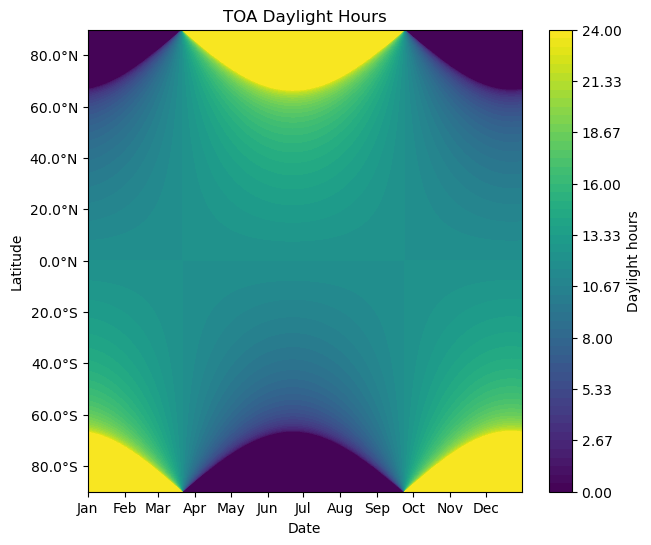

In [56]:
plt.figure(figsize=(7, 6))
contour = plt.contourf(d_n, phi_lat, daylight_hours, cmap='viridis', levels=np.linspace(0, 24, 55))
# contour = plt.contourf(d_n, phi_lat, daylight_hours, cmap='viridis', levels=np.linspace(min_value, max_value, num_levels))
plt.colorbar(contour, label='Daylight hours')
cbar.set_ticks(range(0, 24+2, 2))
plt.xlabel('Date')
plt.gca().xaxis.set_major_locator(MonthLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%b'))
plt.ylabel('Latitude')
plt.gca().yaxis.set_major_formatter(lambda value, tick_number: f'{abs(value)}°{"N" if value >= 0 else "S"}')
plt.title(f'TOA Daylight Hours')
plt.show()

In [57]:
ds = xr.DataArray(daylight_hours, dims=('latitude', 'n_day'), coords={'latitude': phi_lat, 'n_day': d_n})
ds.coords['date'] = ('n_day', dates)

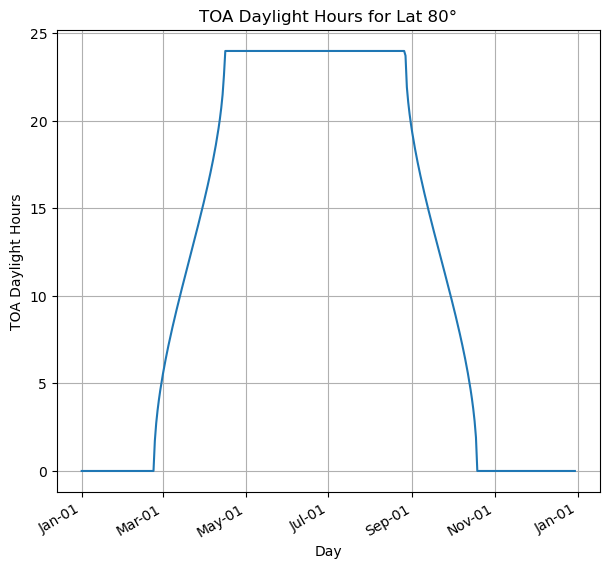

In [59]:
fixed_lat = 80

# nearest_index = np.abs((ds.latitude - fixed_lat)).argmin()
# nearest_latitude = ds.latitude.isel(latitude=nearest_index).values

plt.figure(figsize=(7, 6))
ds.sel(latitude=fixed_lat, method='nearest').plot.line(x='date')

date_formatter = DateFormatter('%b-%d')
plt.gca().xaxis.set_major_formatter(date_formatter)

plt.xlabel('Day')
plt.ylabel('TOA Daylight Hours')
plt.title(f'TOA Daylight Hours for Lat {fixed_lat}°')
plt.grid(True)
plt.show()

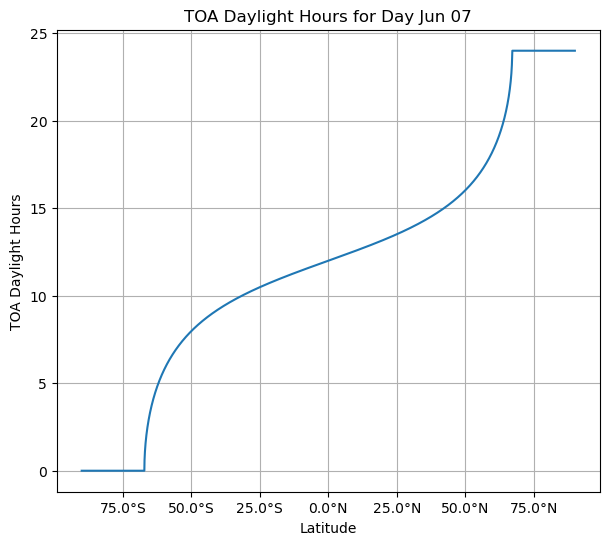

In [60]:
fixed_day = datetime(2024, 6, 7, 0, 0) # Y-M-D
fixed_day_of_year = fixed_day.timetuple().tm_yday

plt.figure(figsize=(7, 6))
ds.sel(n_day=fixed_day_of_year).plot.line(x='latitude')
plt.xlabel('Latitude')
plt.ylabel('TOA Daylight Hours')
plt.gca().xaxis.set_major_formatter(lambda value, tick_number: f'{abs(value)}°{"N" if value >= 0 else "S"}')
formatted_date = fixed_day.strftime('%b %d')
plt.title(f'TOA Daylight Hours for Day {formatted_date}')
plt.grid(True)
plt.show()

In [32]:
'''
Calculate Monthly Average Daylight Hours
'''

'\nCalculate Monthly Average Daylight Hours\n'

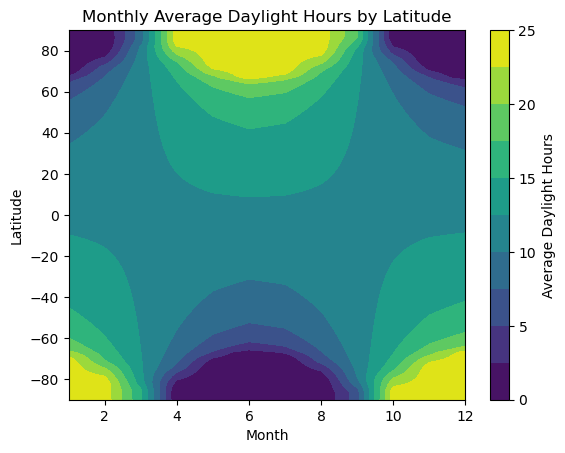

In [33]:
months = ds['date'].dt.month
# Add the 'month' coordinate to the existing DataArray
ds = ds.assign_coords(month=months)
monthly_average = ds.groupby('month').mean(dim='n_day')

contour = plt.contourf(monthly_average.month, monthly_average.latitude, monthly_average.values, cmap='viridis', levels=10)
plt.xlabel('Month')
plt.ylabel('Latitude')
plt.title('Monthly Average Daylight Hours by Latitude')
plt.colorbar(contour, label='Average Daylight Hours')
plt.show()